# Modules, functions

In [ ]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

# Data

In [ ]:
dat0 = pd.read_csv('data/ch4k_df.csv')
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc',
                                  'brand_desc', 'bus_unit_desc', 'rmh_cat_desc'])

# Remove clearance transactions!!
dat0['clearance'] = dat0.clearance.fillna(0) 
dat0['net_qty'] = (1 - dat0.clearance)*dat0.net_qty

In [ ]:
dat0.head()

# Magic

In [158]:
dat = dat0.copy()

dat = dat[(dat.net_qty != 0) & (dat.season.isin(['FW15', 'FW16', 'FW17', 'FW18', 'FW19']))].round()

dat = dat[['article_number', 'season', 'season_net_qty', 'art_desc', 'sports_cat_desc',
       'rmh_cat_desc', 'franchise', 'gender_desc', 'age_group_desc',
       'prod_grp_desc', 'prod_type_desc', 'price', 'margin', 'cost']].drop_duplicates()

dat = (
    dat.
    sort_values(['article_number', 'season']).
    drop_duplicates(subset = 'article_number').
    set_index('article_number').
    dropna()
      )

dat[['price', 'margin', 'cost']] = dat[['price', 'margin', 'cost']].astype('int')

dat = dat[dat.season_net_qty > 50]

In [162]:
dat.sort_values('season_net_qty', ascending = False)

,season,season_net_qty,art_desc,sports_cat_desc,rmh_cat_desc,franchise,gender_desc,age_group_desc,prod_grp_desc,prod_type_desc,price,margin,cost
article_number,,,,,,,,,,,,,
CP9366,FW18,210164,YEEZY BOOST 350 V2,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),180,137,43
AH2203,FW17,88614,YEEZY BOOST 350 V2,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),182,143,39
C77124,FW15,51436,SUPERSTAR,ORIGINALS,ORIGINALS,SUPERSTAR,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),67,55,12
FW3043,FW19,32704,YEEZY BOOST 350 V2,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),178,138,40
CP9654,FW17,27468,YEEZY BOOST 350 V2,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),157,107,49
FW3042,FW19,26524,YEEZY BOOST 350 V2,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),179,139,40
EE7287,FW18,26492,YEEZY 500,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),161,126,36
F36640,FW18,25647,YEEZY 500,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),162,131,31
FU9006,FW19,24063,YEEZY BOOST 350 V2,ORIGINALS,YEEZY,NOT APPLICABLE,MEN,ADULT,SHOES,SHOES - LOW (NON FOOTBALL),169,129,40


In [ ]:
len(dat.index.unique())
dat.shape
pd.crosstab(index = dat.season, columns = 'count').head() # new articles by season
# dat[dat.article_number == '015110']
dat.head()
dat.loc['015110']

In [ ]:
# Algorithm
# 1. select artice
# 2. select category
# 3. filter by same level of category
# 4. filter by similar price
# 5. retrieve net quantites
# 6. repeat 2 - 5 for all categories

In [ ]:
int(9 - .2*9)
int(p) in range(int(p - 0.2*p), int(p + 0.2*p))

In [239]:
dat.loc['DZ9385']


season                       FW19
season_net_qty               5568
art_desc             CUSH LOW 3PP
sports_cat_desc          TRAINING
rmh_cat_desc             TRAINING
franchise          NOT APPLICABLE
gender_desc                UNISEX
age_group_desc              ADULT
prod_grp_desc               SOCKS
prod_type_desc      NO SHOW SOCKS
price                           8
margin                          6
cost                            2
Name: DZ9385, dtype: object

In [207]:
from itertools import permutations 
from itertools import combinations
c = combinations([1, 2, 3], 2) 
for i in list(c): 
    print(i)
    print(i[1])

(1, 2)
2
(1, 3)
3
(2, 3)
3


In [228]:
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

nCr(6,2)
nCr(6,3)
nCr(6,4)
nCr(6,5)

15.0

20.0

15.0

6.0

In [286]:
art = np.random.choice(dat.index, size = 1, replace = False)
# dat_GAS = dat_GAS[dat_GAS.article_number.isin(dat_GAS_a)]

In [287]:
d = {}
cats = ['sports_cat_desc', 'rmh_cat_desc', 'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc']

# Create tidy dataframe, add results to it

for a in art:
    p = dat.loc[a, 'price']
    
    net_qtys = pd.Series()
    
    dat_p = dat[[price in range(int(p - 0.2*p), int(p + 0.2*p)) for price in dat.price]]
    
    for c in cats: 
        dat_a = dat_p[dat_p[c] == dat_p.loc[a, c]] # filter to that level of that category        
        net_qtys = net_qtys.append(dat_a.season_net_qty)
    print(len(net_qtys))
    
    for c2 in combinations(cats, 2):
        dat_a = dat_p[(dat_p[c2[0]] == dat_p.loc[a, c2[0]]) &
                      (dat_p[c2[1]] == dat_p.loc[a, c2[1]])]
        net_qtys = net_qtys.append(dat_a.season_net_qty)
    print(len(net_qtys))
        
    for c3 in combinations(cats, 3):
        dat_a = dat_p[(dat_p[c3[0]] == dat_p.loc[a, c3[0]]) &
                      (dat_p[c3[1]] == dat_p.loc[a, c3[1]]) &
                      (dat_p[c3[2]] == dat_p.loc[a, c3[2]])]
        net_qtys = net_qtys.append(dat_a.season_net_qty)
    print(len(net_qtys))
    
    for c4 in combinations(cats, 4):
        dat_a = dat_p[(dat_p[c4[0]] == dat_p.loc[a, c4[0]]) &
                      (dat_p[c4[1]] == dat_p.loc[a, c4[1]]) &
                      (dat_p[c4[2]] == dat_p.loc[a, c4[2]]) &
                      (dat_p[c4[3]] == dat_p.loc[a, c4[3]])]
        net_qtys = net_qtys.append(dat_a.season_net_qty)
    print(len(net_qtys))
    
    for c4 in combinations(cats, 5):
        dat_a = dat_p[(dat_p[c4[0]] == dat_p.loc[a, c4[0]]) &
                      (dat_p[c4[1]] == dat_p.loc[a, c4[1]]) &
                      (dat_p[c4[2]] == dat_p.loc[a, c4[2]]) &
                      (dat_p[c4[3]] == dat_p.loc[a, c4[3]]) &
                      (dat_p[c4[4]] == dat_p.loc[a, c4[4]])]
        net_qtys = net_qtys.append(dat_a.season_net_qty)
    print(len(net_qtys))
    
    for c4 in combinations(cats, 6):
        dat_a = dat_p[(dat_p[c4[0]] == dat_p.loc[a, c4[0]]) &
                      (dat_p[c4[1]] == dat_p.loc[a, c4[1]]) &
                      (dat_p[c4[2]] == dat_p.loc[a, c4[2]]) &
                      (dat_p[c4[3]] == dat_p.loc[a, c4[3]]) &
                      (dat_p[c4[4]] == dat_p.loc[a, c4[4]]) &
                      (dat_p[c4[5]] == dat_p.loc[a, c4[5]])]
        net_qtys = net_qtys.append(dat_a.season_net_qty)
    print(len(net_qtys))
    
    d[a] = net_qtys 
    # Would need to restart net_qtys each new article... 
        
        
    


24676
55959
79954
92318
96864
97956


In [288]:
dat[dat.index == art[0]][['season', 'season_net_qty', 'sports_cat_desc', 'rmh_cat_desc', 'franchise', 'price', 'margin', 'cost']]

minimize_EL(net_qtys, dat.loc[a, 'margin'], dat.loc[a, 'cost'])
net_qtys.describe()


,season,season_net_qty,sports_cat_desc,rmh_cat_desc,franchise,price,margin,cost
article_number,,,,,,,,
BS8229,FW17,434,RUNNING,CLASSICS,CLASSIC LEATHER,71,56,15


482

count    97956.000000
mean       402.624209
std        802.023861
min         51.000000
25%        105.000000
50%        198.000000
75%        415.000000
max      51436.000000
dtype: float64

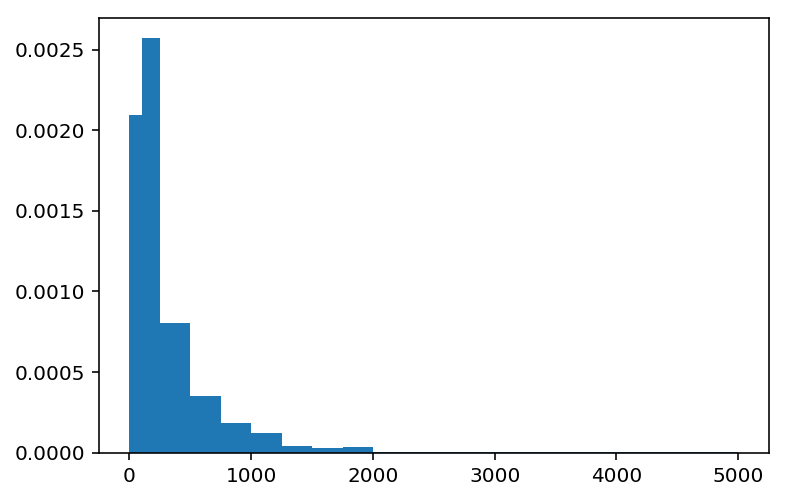

In [284]:
plt.hist(net_qtys, bins = [0, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 5000], density = True)

pass;

In [283]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(net_qtys)

ecdf([100, 500, 1000, 3000])


array([0.21458891, 0.79488976, 0.92818875, 0.99513703])

In [ ]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'G26535'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'corrected', 'y_hat']]
        

plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['net_qty', 'corrected', 'y_hat']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# dat_aoi

# Optimal Buy

In [ ]:
from functools import partial
from scipy import optimize
from scipy import integrate
import scipy.stats as stats

In [175]:
# Loss --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:    # CANNOT satisfy demand
        return (d - b)*margin
    
    elif d <= b: # CAN satisfy demand
        return (b - d)*cost
    
    else:
        print('Error')

# E[L | buy, article_mean, article_sd, article_margin, article_cost]
def EL(net_qtys, margin, cost, b):
    return sum([L(x, b, margin, cost) for x in net_qtys])/len(net_qtys)

def minimize_EL(net_qtys, margin, cost):
    p = partial(EL, net_qtys, margin, cost) # Make EL function of only one var
    mu = np.mean(net_qtys)
    buy_opt = optimize.minimize_scalar(p, bounds = (mu, mu + 2*np.std(net_qtys)))
    return int(buy_opt['x']) # optimal buy quantity

In [176]:
# Profit
def P(d, margin, cost, b):
    if d > b:    # CANNOT satisfy demand
        return b*margin
    
    elif d <= b: # CAN satisfy demand
        return d*margin - (b - d)*cost
    
    else:
        print('Error')

def EP(net_qtys, margin, cost, b):
    return -sum([P(x, margin, cost, b) for x in net_qtys])/len(net_qtys)

def maximize_EP(net_qtys, margin, cost):
    p = partial(EP, net_qtys, margin, cost) # Make EL function of only one var
    mu = np.mean(net_qtys)
    buy_opt = optimize.minimize_scalar(p, bounds = (mu, mu + 2*np.std(net_qtys)))
    return int(buy_opt['x']) # optimal buy quantity

In [253]:
# one offs

# # Minimize Loss
# l = partial(EL, net_qtys, 63, 30) # Make EL function of only one var
# [print(x, ':', round(l(x))) for x in range(0, 600, 50)]

# # Maximize Profit
# p = partial(EP, net_qtys, 63, 30)
# [print(x, ':', round(p(x))) for x in range(0, 600, 50)]


minimize_EL(net_qtys, 6, 2)
                          
maximize_EP(net_qtys, 6, 2)

# HUZZAH!!!!!


4319

4319

In [ ]:


# --- Overbuy statistics ---
# preds_season['pct_overbuy'] = (preds_season.Opt_Ovb - preds_season.y_hat)/preds_season.y_hat*100
# b = np.array([0, 1000, 2000, 5000, 10000, 50000])
# preds_season['bins'] = pd.cut(preds_season.y_hat, bins = b)
# preds_season.groupby('bins')['pct_overbuy'].describe().round()
